DEL 1 Utforska datat

- 1.1   Läs in filen agent_data.csv till ett Pandas DataFrame.

    Jag börjar med att importera modulen pandas som "pd". Därefter gör jag en variabel med sökvägen till csvfilen och 
    till sist använder jag modulen pandas till att läsa csvfilen till en dataframe.    


In [44]:
import pandas as pd

In [45]:
data = "C:/VScode projects/Lektion1/agent_data.csv"
#sökväg till filen

In [46]:
df = pd.read_csv(data)
#skapar en dataframe från csv filen

- 1.2   Skriv ut kolumnnamnen och datatyperna. Vid första anblick, finns det någon datatyp som bör konverteras? Följer kolumnnamnen en bra standard?

    Med hjälp av **df.dtypes** kan man se alla datatyper på kolumnerna. Det krävs kanske lite mer efterforskning för att göra ett beslut om vilka datatyper som behöver ändras. Vid första anblick behöver **Timestamp_** ändras till datatypen datetime. Man behöver ändra plats och ta bort underscore i kolumnnamnen så de följer en bra standard.
    Gör kolumnnamnen mer enhetliga utan mellanrum och separata underscores istället för "space", allt är i lowercases.

In [47]:
df.dtypes
#kollar datatyperna i varje kolumn

Prompt_ ID_               object
Timestamp_                object
Customer_ Name_           object
Customer_ Segment_        object
City_                     object
Country_                  object
Agent_ Name_              object
LLM_ Model_               object
Compute_ Cost_ EUR_      float64
Customer_ Price_ EUR_    float64
Response_ Time_            int64
Use_ Case_                object
Prompt_ Length_            int64
Access_ Method_           object
dtype: object

In [48]:
df.columns = (
    df.columns.str.strip().str.replace(" ", "_").str.replace("__", "_").str.rstrip("_").str.lower()
)
#städar upp kolumnnamnen och gör kolumnnamn enhetliga

In [49]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
#ändrar datatypen på timestamp kolumnen till datetime

In [50]:
df.info()
#validerar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563458 entries, 0 to 563457
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   prompt_id           563458 non-null  object        
 1   timestamp           563458 non-null  datetime64[ns]
 2   customer_name       563458 non-null  object        
 3   customer_segment    563458 non-null  object        
 4   city                563458 non-null  object        
 5   country             563458 non-null  object        
 6   agent_name          563458 non-null  object        
 7   llm_model           563458 non-null  object        
 8   compute_cost_eur    563458 non-null  float64       
 9   customer_price_eur  563458 non-null  float64       
 10  response_time       563458 non-null  int64         
 11  use_case            518219 non-null  object        
 12  prompt_length       563458 non-null  int64         
 13  access_method       551474 no


- 1.3   Det finns ett känt fel i datat, specifikt i kolumnen Access method’. Du har fått OK att fylla dessa tomma värden med ”CLI”.

    Med hjälp av fillna kan man fylla none. Här med en string **"CLI"**


In [51]:
df["access_method"] = df["access_method"].fillna("CLI")
#fyller i tomma värden i access_method med "CLI"


- 1.4   Finns det andra kolumner som saknar värden i datat? Om det finns, hur hanterar du dom?

    Ja kolumnen Use_case har också ett antal nullvärden närmare bestämt 8.7 %. När man undersöker närmare så ser man att Agent_name och Use_case interagerrar med varandra. Med hjälp av agent_name kolumnen kan jag fylla use_case med deras saknade värden.

In [52]:
missing_count = df["use_case"].isna().sum()
total_count = df["use_case"].count()
summa_procent = (missing_count / total_count) * 100
print("Antal saknade procent i use_case:", summa_procent)

Antal saknade procent i use_case: 8.729706938572303


In [53]:
# Fyll NaN i use_case med det vanligaste värdet per agent_name
df["use_case"] = df.groupby("agent_name")["use_case"].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown")
)


- 1.5   Utforska innehållet i kolumnerna. Finns det tecken på dålig datakvalitet? Felstavningar?

    Novalogic AB är skrivet på flera sätt i Customer_name tex ibland med bara upper cases och ibland inte.
    'stockholm och Stockholm i city.
    sweden har tre benämningar i country.
   jag gör en funktion som heter **standardize_columns** för att **städa** denna data.
   column_mappings anger vad saker ska bytas ut till. Hade det varit ett större set med data så hade jag gjort en mer clean funktion
   som tar bort alla möjliga tecken, unicode, radbrytningar, tab etc.    
        

In [54]:
df["city"].value_counts()
#med hjälp av value_counts kan räkna ut hur många unika värden det finns i en kolumn

city
Stockholm        215690
Gothenburg        84528
Malmö             56165
Oslo              31622
Toronto           24251
Helsinki          21791
New York          21178
London            20565
San Francisco     18596
Östersund         16808
Berlin            14156
Copenhagen        12049
Vancouver          9378
Frankfurt          8543
'stockholm         8138
Name: count, dtype: int64

In [55]:
def standardize_columns(df, column_mappings):
    """
    Standardiserar värden i flera kolumner enligt angivna mappings.
    
    column_mappings: dict
        Key = kolumnnamn
        Value = mapping dictionary (key = "original value", value = "standardiserad value")
    """
    for col, mapping in column_mappings.items():
        if col not in df.columns:
            continue  # hoppa kolumn som inte finns
        # Ersätt direkt med mapping
        df[col] = df[col].replace(mapping)
    return df



In [56]:
column_mappings = {
    "customer_name": {
        "novalogicab": "NovaLogic AB",
        "NOVALOGIC  AB": "NovaLogic AB",
    },
    "city" : {
        "stockholm": "Stockholm",
        "STOCKHOLM": "Stockholm",
        "'stockholm": "Stockholm",
    },
    "country": {
        "Swedne": "Sweden",
        "'sweden": "Sweden",
    }
}

df = standardize_columns(df, column_mappings)
#  använder funktionen för att städa data i specifika kolumner  


DEL 2 Modeller och Agenter

- 2.1 Visualisera användningen av våra olika LLMs. Hur många prompts har varje unik modell hanterat?

Jag börjar importera visualiseringsmodulerna seaborn och matplotlib. Skapar ett nytt dataframe genom att splitta värdena i llm_model.
Genom att räkna det unika antalet modeller med **value_counts** kan jag se antalet prompts

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
#  använder matplotlib och seaborn för att visualisera data

In [58]:
# 1. Splitta strängar på ", " och skapa en lista
df["llm_model_list"] = df["llm_model"].str.split(", ")

# 2. “Explode” listan så att varje modell får en egen rad
df_exploded = df.explode("llm_model_list")

# 3. Räkna antal per unik modell
model_counts = df_exploded["llm_model_list"].value_counts()
print(model_counts)


llm_model_list
sagitta-3.i    162518
orion-k4       135640
nordix-7.i     117051
sagitta-4.i    108152
orion-k3        98923
maya-1.i        90100
kiwi-2.i        71960
bonus-5.i       62937
alva-1.i        53916
Name: count, dtype: int64


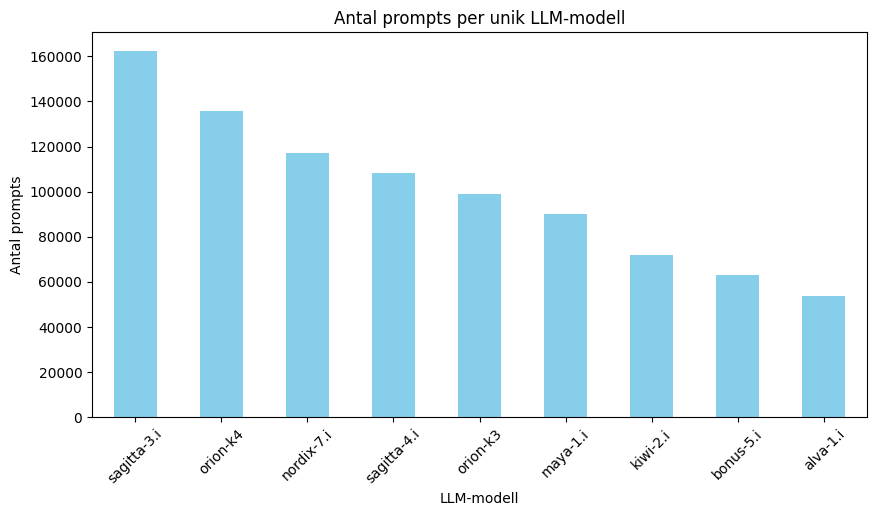

In [59]:
plt.figure(figsize=(10,5))
model_counts.plot(kind="bar", color="skyblue")
plt.title("Antal prompts per unik LLM-modell")
plt.xlabel("LLM-modell")
plt.ylabel("Antal prompts")
plt.xticks(rotation=45)
plt.show()


- 2.2 Hur ser användningen ut för våra agenter?

Jag har valt att visualisera detta också istället för en print eftersom jag tycker man får en bättre överblick. Jag la in exakta värden i staplarna och centrerade dem istället för en enkel print() på variabeln agent_counts

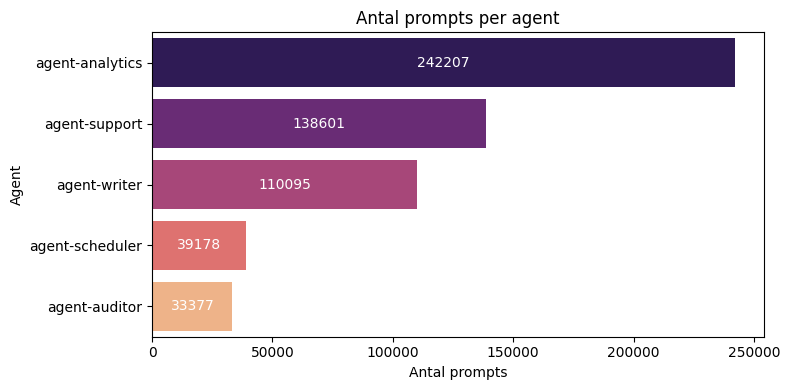

In [60]:
agent_counts = df["agent_name"].value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(
    x=agent_counts.values,
    y=agent_counts.index,
    hue=agent_counts.index,
    palette="magma",
    legend=False
)

# Lägg till värde inuti staplarna för bättre läsbarhet och exakta värden
for i, v in enumerate(agent_counts.values):
    ax.text(v / 2, i, str(v), color='white', va='center', ha='center')  

plt.title("Antal prompts per agent")
plt.xlabel("Antal prompts")
plt.ylabel("Agent")
plt.tight_layout()
plt.show()

- 2.3 Vi har fått klagomål om att vissa agenter är långsamma, kan du undersöka responstiden på våra agenter? Resulterar långsamma modeller lägre användning?

Jag har valt att visualisera detta också med scatterplot och regplot i seaborn (tyvärr inte så bra som jag velat ha det, y-axeln blir väldigt osammanhängade med datat). Variabeln agent_stats har uträknad statistik. 
I correlation variabeln räknar jag ut sambandet mellan agenter och responstiden. Jag får då ett måttligt negativt samband **(r = –0.48)** mellan agenter­nas genomsnittliga svarstid och antalet prompts de hanterar. Agenter som hanterar fler ärenden svarar i genomsnitt snabbare, vilket tyder på att högre belastning inte sänker effektiviteten.
Sen finns det säkert bakomliggande variablar. Som att scheduling tar längre tid än andra uppgifter eftersom de använder email drafting i Use_case. Det kan kräva andra resurser än de andra uppgifterna och påverka svarstiderna.

In [61]:
df_agent_sched = df.loc[df["agent_name"] == "agent-scheduler"]
df_agent_sched


,prompt_id,timestamp,customer_name,customer_segment,city,country,agent_name,llm_model,compute_cost_eur,customer_price_eur,response_time,use_case,prompt_length,access_method,llm_model_list
6,3b607e53-8d9e-11f0-99ec-0a623090504c,2024-01-01 08:00:08,Kira Consulting AB,Consultancy,Gothenburg,Sweden,agent-scheduler,"sagitta-4.i, sagitta-3.i",0.0099,0.0194,3468,Email Drafting,240,Web,"[sagitta-4.i, sagitta-3.i]"
9,3afe2331-8d9e-11f0-afa5-0a623090504c,2024-01-01 08:00:16,NovaLogic AB,Startup,Stockholm,Sweden,agent-scheduler,"kiwi-2.i, orion-k4, orion-k4",0.0212,0.0302,3484,Email Drafting,118,Web,"[kiwi-2.i, orion-k4, orion-k4]"
21,3b3ec532-8d9e-11f0-b13e-0a623090504c,2024-01-01 08:00:28,NeuroNova AB,Startup,Stockholm,Sweden,agent-scheduler,"sagitta-4.i, maya-1.i, kiwi-2.i",0.0255,0.0414,5840,Email Drafting,106,App,"[sagitta-4.i, maya-1.i, kiwi-2.i]"
28,3fb4fca2-8d9e-11f0-a1f5-0a623090504c,2024-01-01 08:00:36,Kira Consulting AB,Consultancy,Gothenburg,Sweden,agent-scheduler,"nordix-7.i, sagitta-3.i",0.0125,0.0245,6888,Email Drafting,104,Web,"[nordix-7.i, sagitta-3.i]"
60,272aa48b-8d9e-11f0-a716-0a623090504c,2024-01-01 08:15:15,Kira Consulting AB,Consultancy,Gothenburg,Sweden,agent-scheduler,orion-k4,0.0077,0.0151,2682,Email Drafting,101,Plugin,[orion-k4]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563414,3f532533-8d9e-11f0-8bab-0a623090504c,2025-07-31 20:30:05,HyperByte Inc,Enterprise,Toronto,Canada,agent-scheduler,orion-k4,0.0103,0.0124,3082,Email Drafting,133,API,[orion-k4]
563416,3af258fd-8d9e-11f0-9937-0a623090504c,2025-07-31 20:30:32,Best Practice LLC,Enterprise,New York,USA,agent-scheduler,orion-k4,0.0030,0.0057,2049,Email Drafting,65,Web,[orion-k4]
563431,40f9aa87-8d9e-11f0-baae-0a623090504c,2025-07-31 22:00:29,Best Practice LLC,Enterprise,New York,USA,agent-scheduler,"alva-1.i, sagitta-4.i",0.0161,0.0300,6552,Email Drafting,87,App,"[alva-1.i, sagitta-4.i]"
563451,2fb842c4-8d9e-11f0-bd9d-0a623090504c,2025-07-31 23:30:06,DataForge Inc,Enterprise,Vancouver,Canada,agent-scheduler,nordix-7.i,0.0032,0.0049,2753,Email Drafting,52,Web,[nordix-7.i]


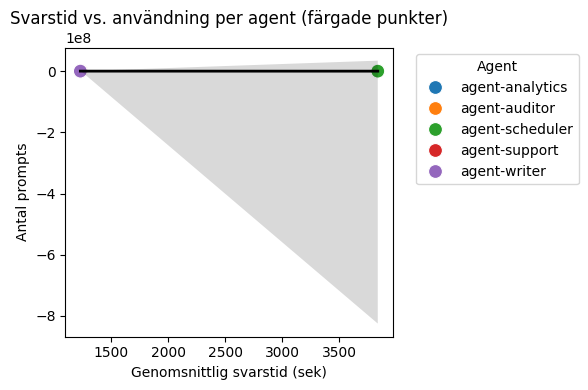

korrelation: -0.48
        agent_name  mean_response_time  prompts_handled
0  agent-analytics         1236.494296           242207
1    agent-auditor         1237.161488            33377
2  agent-scheduler         3838.864975            39178
3    agent-support         1236.880607           138601
4     agent-writer         1230.802407           110095


In [62]:
# Beräkna statistik per agent
agent_stats = (
    df.groupby("agent_name")
      .agg(
          mean_response_time=("response_time", "mean"),
          prompts_handled=("prompt_id", "count")
      )
      .reset_index()
)

# Scatterplot med regressionslinje och färg per agent
plt.figure(figsize=(6,4))
sns.scatterplot(
    x="mean_response_time",
    y="prompts_handled",
    hue="agent_name",         # färg per agent
    palette="tab10",          # välj färgpalett
    s=100,                    # storlek på punkterna
    data=agent_stats
)

# Lägg till linjär regressionslinje
sns.regplot(
    x="mean_response_time",
    y="prompts_handled",
    data=agent_stats,
    scatter=False,            # ingen extra scatter
    color="black",            # regressionslinje svart
    line_kws={"linewidth":2}
)

plt.title("Svarstid vs. användning per agent (färgade punkter)")
plt.xlabel("Genomsnittlig svarstid (sek)")
plt.ylabel("Antal prompts")
plt.legend(title="Agent", bbox_to_anchor=(1.05, 1), loc=2)  # flytta legend
plt.tight_layout()
plt.show()

# korrelation
correlation = agent_stats["mean_response_time"].corr(agent_stats["prompts_handled"])
print(f"korrelation: {correlation:.2f}")
print(agent_stats)


- 2.3b Skapa en ny kolumn ’llm_count’ som räknar hur många unika modeller som använts i varje prompt. Som du säkert har märkt så kan en prompt hanteras av flera modeller.

    jag räknar hur många unika LLM-modeller som använts för varje prompt (rad), även om modellen förekommer flera gånger eller med extra blanksteg, och sparar det antalet i en ny kolumn llm_count.

In [63]:
# Skapa ny kolumn med antal unika modeller per prompt
df["llm_count"] = df["llm_model"].apply(lambda x: len(set([m.strip() for m in x.split(",")])))


In [64]:
df[["llm_model", "llm_count"]].head()
#validera

,llm_model,llm_count
0,orion-k4,1
1,kiwi-2.i,1
2,sagitta-4.i,1
3,"kiwi-2.i, alva-1.i, orion-k3, orion-k4",4
4,maya-1.i,1


- 2.4 Visualisera hur många prompts som hanterats grupperat på ’llm_count’. **Det är intressant att veta hur ofta vi behöver använda fler modeller i en prompt för att lösa kundernas uppgifter.**

    samma här så använder jag mig av value_counts på den nya kolumnen llm_count. Med hjälp av index kan man räkna hur många gånger det har till exempel behövts 1,2,3 eller 4 llm_modeller. 


C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\2568178702.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


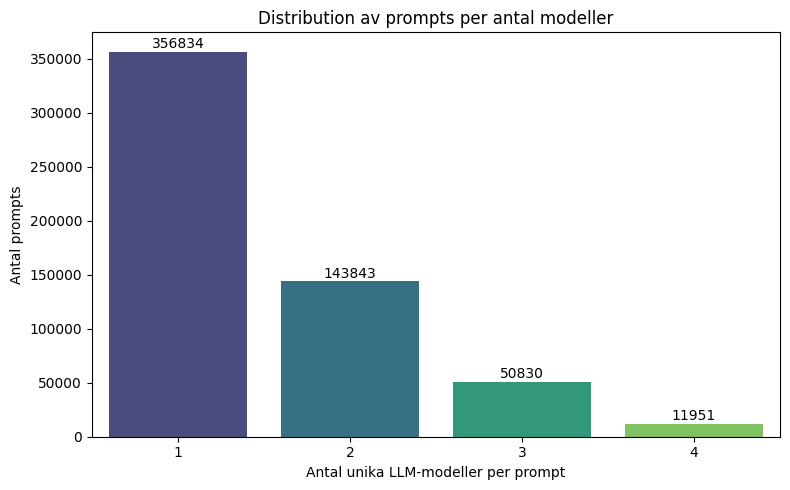

In [65]:
# Räknar antal prompts per llm_count
llm_distribution = df["llm_count"].value_counts().sort_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=llm_distribution.index,
    y=llm_distribution.values,
    palette="viridis"
)

# Lägg till värden ovanpå varje stapel
for i, v in enumerate(llm_distribution.values):
    ax.text(i, v + max(llm_distribution.values)*0.01, str(v), color='black', ha='center')

plt.xlabel("Antal unika LLM-modeller per prompt")
plt.ylabel("Antal prompts")
plt.title("Distribution av prompts per antal modeller")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Del 3: Användarbeteende – Prompts, segment och trender
- 3.1 Visualisera promptanvändning månadsvis med en linjegraf.

    Jag gör om timestamp kolumnen i en ny dataframe till date to month. med den dataframen kan man ta och göra en ny variabeln där man räknar ut antalet prompts per månad. jag visar sedan upp detta i en linechart med seaborn.

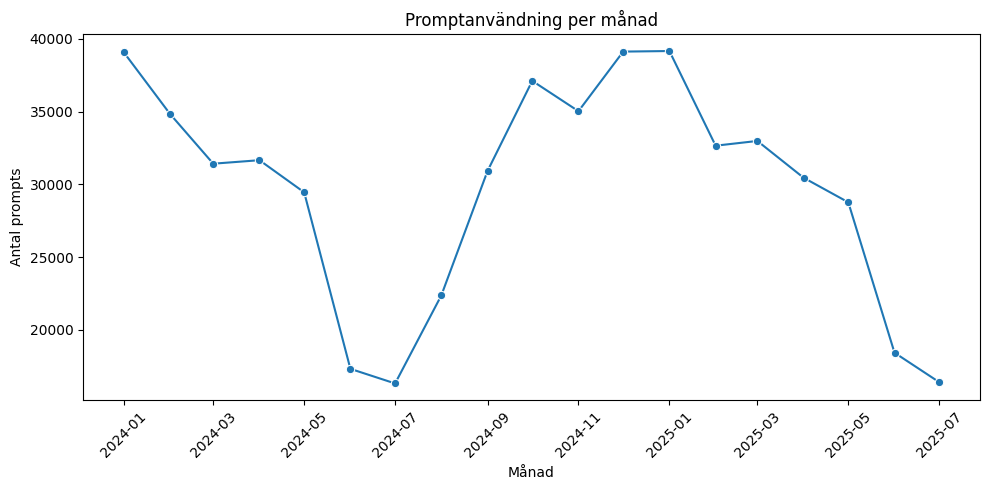

In [66]:
# Skapa en kolumn med år-månad för gruppering
df['year_month'] = df['timestamp'].dt.to_period('M')

# Räkna antal prompts per månad
monthly_prompts = df.groupby('year_month')['prompt_id'].count().reset_index()
monthly_prompts['year_month'] = monthly_prompts['year_month'].dt.to_timestamp()  # konvertera tillbaka till timestamp för plot

# Linjegraf
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_prompts, x='year_month', y='prompt_id', marker='o')
plt.xlabel("Månad")
plt.ylabel("Antal prompts")
plt.title("Promptanvändning per månad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 3.2 På vilka sätt anropar kunderna våra agenter? (Access method)

    Här gör jag bara en valuecount på access_method. Web dominerar med 296575 stycken

C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\2012458576.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


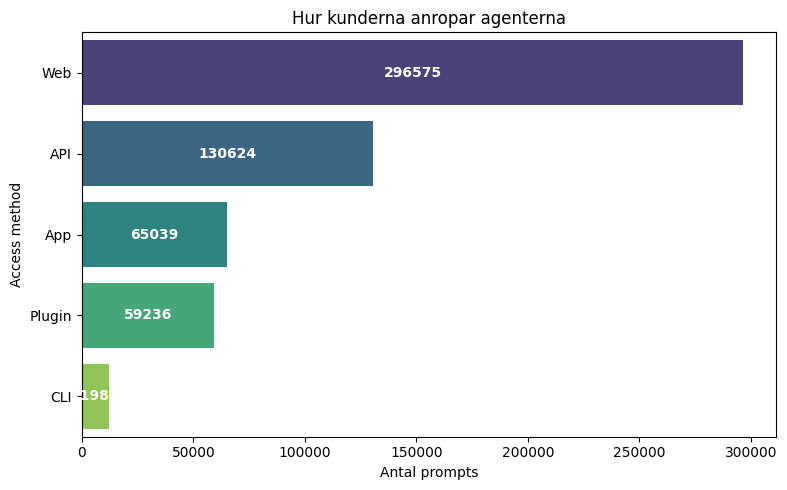

In [67]:
# Räkna antal per access method
access_counts = df['access_method'].value_counts()

# Visa resultatet som liggande barplot
plt.figure(figsize=(8,5))
ax = sns.barplot(
    y=access_counts.index,
    x=access_counts.values,
    palette="viridis"
)

# Lägg till exakta värden inuti staplarna
for i, v in enumerate(access_counts.values):
    ax.text(v / 2, i, str(v), color='white', va='center', ha='center', fontweight='bold')

plt.xlabel("Antal prompts")
plt.ylabel("Access method")
plt.title("Hur kunderna anropar agenterna")
plt.tight_layout()
plt.show()


- 3.3 Visualisera antal prompts per Use Case, Country och Customer Segment. Om de går, visa gärna visualiseringarna parallelt för att kunna läsa av resultatet bättre.

    samma sak här. gör nya dataframes och gör valuecounts på vald kolumn. eftersom datat är städat sen tidigare slipper jag stavfel.
    för att visa dem bredvid varandra använder jag subplot.

C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\114181889.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\114181889.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\114181889.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


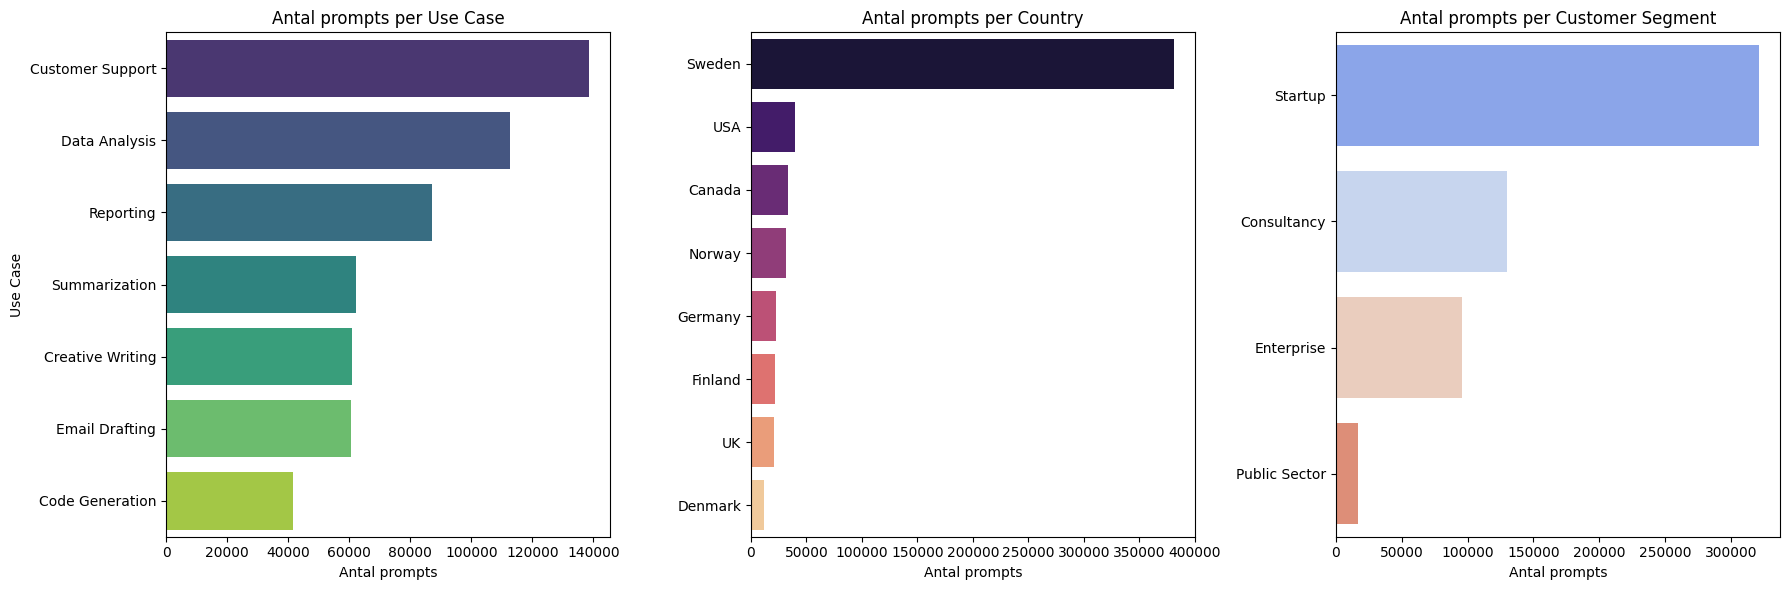

In [68]:
# Räkna antal prompts per kategori
use_case_counts = df['use_case'].value_counts().sort_values(ascending=False)
country_counts = df['country'].value_counts().sort_values(ascending=False)
segment_counts = df['customer_segment'].value_counts().sort_values(ascending=False)

# Skapa en figur med 3 subplotar bredvid varandra
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Use Case
sns.barplot(
    x=use_case_counts.values,
    y=use_case_counts.index,
    ax=axes[0],
    palette="viridis"
)
axes[0].set_title("Antal prompts per Use Case")
axes[0].set_xlabel("Antal prompts")
axes[0].set_ylabel("Use Case")

# Country
sns.barplot(
    x=country_counts.values,
    y=country_counts.index,
    ax=axes[1],
    palette="magma"
)
axes[1].set_title("Antal prompts per Country")
axes[1].set_xlabel("Antal prompts")
axes[1].set_ylabel("")

# Customer Segment
sns.barplot(
    x=segment_counts.values,
    y=segment_counts.index,
    ax=axes[2],
    palette="coolwarm"
)
axes[2].set_title("Antal prompts per Customer Segment")
axes[2].set_xlabel("Antal prompts")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

- 3.4 Hur ser fördelningen ut för antal prompts på veckodagsnivå?

    Här skapar jag en kolumn med veckodag från timestamp. På så sätt kan jag räkna antalet prompts per veckodag.
    Jag tara sedan och sorterar dagarna så att de ligger i ordning måndag till söndag med en variabel. Annars är risken att de sorteras efter frekvens. Egentligen kan man göra det utan att skapa en kolumn för att spara datamängd, men jag skulle egentligen gjort alla nya datumkolumner redan från början om det hade varit ett riktigt case. YTD,MTD, "Månad" osv osv

C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\2057565413.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


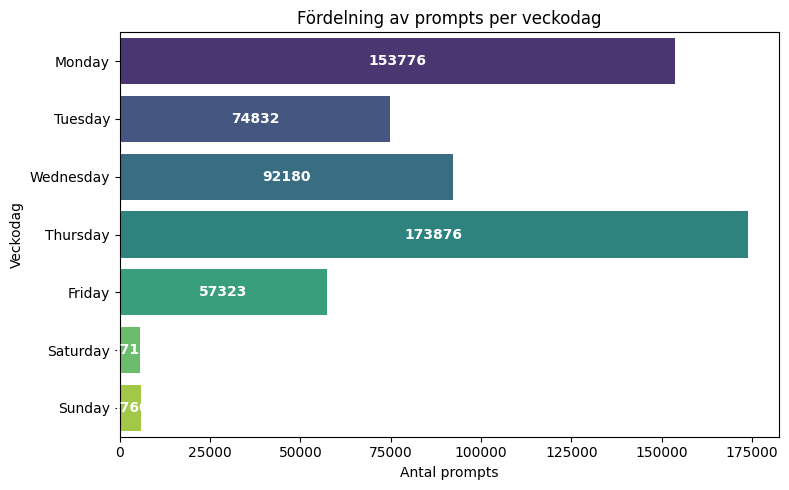

In [69]:
# Extraherar veckodag
df['weekday'] = df['timestamp'].dt.day_name()

# Räknar antal prompts per veckodag
weekday_counts = df['weekday'].value_counts()
# Ordna veckodagar i rätt ordning
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

# Liggande barplot
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=weekday_counts.values,
    y=weekday_counts.index,
    palette="viridis"
)

# Lägg till värden inuti staplarna
for i, v in enumerate(weekday_counts.values):
    ax.text(v / 2, i, str(v), color='white', va='center', ha='center', fontweight='bold')

plt.xlabel("Antal prompts")
plt.ylabel("Veckodag")
plt.title("Fördelning av prompts per veckodag")
plt.tight_layout()
plt.show()


- 3.5 Hur ser fördelningen ut för antal prompts under dagarna? Vilka tider promptas det mest? Visualisera gärna med ett histogram.
Om vi har tydliga peakar i användning skulle vi kunna skruva upp compute under dessa tider för att förbättra användarupplevelsen.

    Samma som tidigare uppgift. skapar en ny kolumn för timme(int) upp till range(24) eftersom 0 är midnatt. Tar och gör valuecount på timmar och visar det med ett histogram.

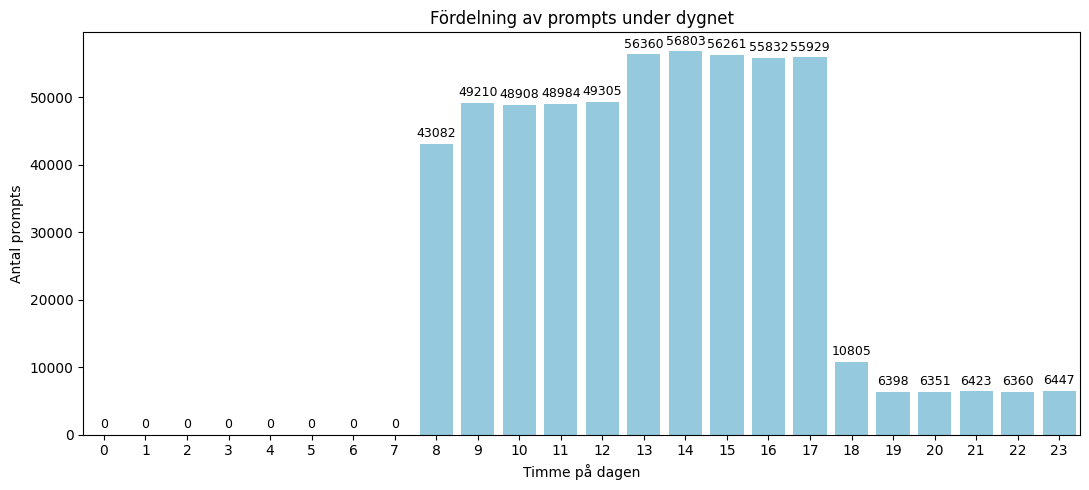

In [70]:
# Extrahera timme från timestamp
df['hour'] = df['timestamp'].dt.hour

# Räkna antal prompts per timme och inkludera alla timmar 0-23
hour_counts = df['hour'].value_counts().sort_index()
all_hours = pd.Series(range(24))
hour_counts = hour_counts.reindex(all_hours, fill_value=0)

plt.figure(figsize=(11,5))
ax = sns.barplot(
    x=hour_counts.index,
    y=hour_counts.values,
    color='skyblue'
)

# Lägg till värden ovanför staplarna
for i, v in enumerate(hour_counts.values):
    ax.text(i, v + max(hour_counts.values)*0.01, str(v), ha='center', va='bottom', fontsize=9)

plt.xlabel("Timme på dagen")
plt.ylabel("Antal prompts")
plt.title("Fördelning av prompts under dygnet")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

Del 4: Vinst, marginaler och värde
- 4.1 Skapa två nya kolumner:
    -	**profit_eur** = customer_price_eur – compute_cost_eur
    -	**margin_pct** = profit_eur / customer_price_eur * 100
    
    skapar nya kolumner genom beräkningar. genom att göra en funktion och med hjälp av lambda x kan jag räkna marginalen för varje rad.
    jag skyddar också division med noll så den returnerar 0 istället för fel.

In [71]:
# Skapar kolumnen profit_eur
df["profit_eur"] = df["customer_price_eur"] - df["compute_cost_eur"]

# Skapar kolumnen margin_pct (i procent)
df["margin_pct"] = (df["profit_eur"] / df["customer_price_eur"]) * 100

# Hanterar division med noll genom att använda lambda-funktionen
df["margin_pct"] = df.apply(
    lambda x: (x.profit_eur / x.customer_price_eur * 100)
              if x.customer_price_eur != 0 else 0,
    axis=1
)


In [72]:
df[["customer_price_eur", "compute_cost_eur", "profit_eur", "margin_pct"]].head()
#validera


,customer_price_eur,compute_cost_eur,profit_eur,margin_pct
0,0.0127,0.0093,0.0034,26.771654
1,0.0222,0.0136,0.0086,38.738739
2,0.0100,0.0062,0.0038,38.000000
3,0.0448,0.0238,0.0210,46.875000
4,0.0109,0.0073,0.0036,33.027523


- 4.2 Vad tjänar vi på våra olika agenter? Visa **’profit_eur’** och **’margin_pct’** per agent.

    Räknar först ut profit per agent. Marginalen visas med den oranga kurvan och total profit på bars.

In [73]:
# Grupp­era per agent och beräkna total profit och genomsnittlig marginal
agent_profit = (
    df.groupby("agent_name")
      .agg(
          total_profit_eur=("profit_eur", "sum"),
          avg_margin_pct=("margin_pct", "mean")
      )
      .sort_values("total_profit_eur", ascending=False)
)

print(agent_profit)


                 total_profit_eur  avg_margin_pct
agent_name                                       
agent-analytics         2011.0765       39.964886
agent-support            960.0271       39.953551
agent-writer             757.1748       39.886550
agent-auditor            275.2009       39.704548
agent-scheduler          267.6723       39.731323


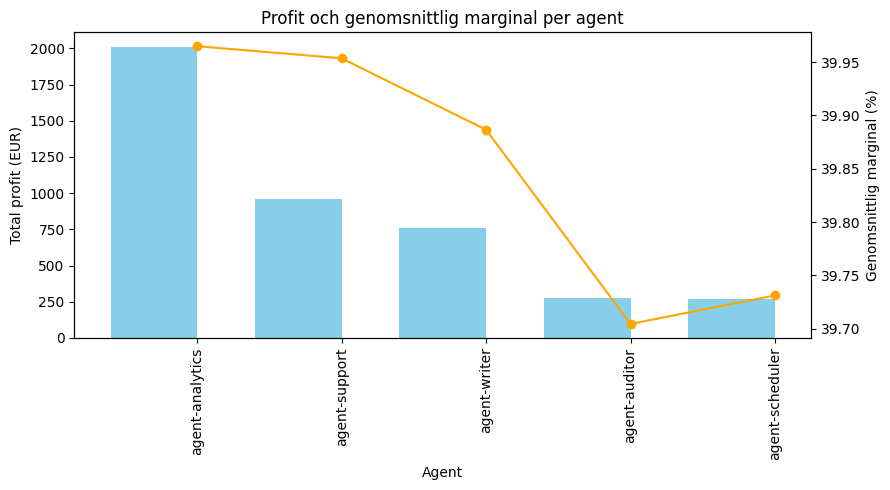

In [74]:
fig, ax1 = plt.subplots(figsize=(9,5))

# Stapeldiagram: total profit
agent_profit["total_profit_eur"].plot(
    kind="bar", color="skyblue", ax=ax1, width=0.6, position=1
)
ax1.set_ylabel("Total profit (EUR)")
ax1.set_xlabel("Agent")
ax1.set_title("Profit och genomsnittlig marginal per agent")

# Linje: genomsnittlig marginal
ax2 = ax1.twinx()
agent_profit["avg_margin_pct"].plot(
    kind="line", color="orange", marker="o", ax=ax2
)
ax2.set_ylabel("Genomsnittlig marginal (%)")

plt.tight_layout()
plt.show()


- 4.3 Beräkna genomsnittlig vinst **(profit_eur)** och genomsnittlig marginal **(margin_pct)** och gruppera datat på följande kolumner separat:
    -	**agent name**
    -	**use case**
    -	**customer segment**
    - Tips: För att undvika att skriva upprepad kod kan du skapa en enkel funktion som tar ”kolumn att gruppera på” som argument och returnerar en tabell med snittvärden för vinst och marginal.

    Skapar en funktion för att beräkna medelvärde av profit och margin per vald kolumn. Sedan gör jag nya variabler på de tre kolumnerna och applicerar funktionen på dem. slutligen printar jag ut värdena.


In [75]:
# Funktion för att beräkna medelvärde av profit och margin per vald kolumn
def mean_profit_margin(df, group_col):
    """
    Returnerar genomsnittlig profit_eur och margin_pct
    grupperat på vald kolumn.
    
    Parameters
    ----------
    df : DataFrame
    group_col : str
        Kolumn att gruppera på (t.ex. 'agent_name')
    """
    return (
        df.groupby(group_col)
          .agg(
              mean_profit_eur=("profit_eur", "mean"),
              mean_margin_pct=("margin_pct", "mean")
          )
          .sort_values("mean_profit_eur", ascending=False)
    )

# variabler för de tre kolumnerna
agent_stats    = mean_profit_margin(df, "agent_name")
usecase_stats  = mean_profit_margin(df, "use_case")
segment_stats  = mean_profit_margin(df, "customer_segment")

print("Per agent:\n", agent_stats.head(), "\n")
print("Per use case:\n", usecase_stats.head(), "\n")
print("Per customer segment:\n", segment_stats.head())


Per agent:
                  mean_profit_eur  mean_margin_pct
agent_name                                       
agent-analytics         0.008303        39.964886
agent-auditor           0.008245        39.704548
agent-support           0.006927        39.953551
agent-writer            0.006877        39.886550
agent-scheduler         0.006832        39.731323 

Per use case:
                   mean_profit_eur  mean_margin_pct
use_case                                          
Code Generation          0.008316        39.970598
Reporting                0.008293        39.903647
Data Analysis            0.008276        39.916350
Summarization            0.007691        40.002886
Customer Support         0.006927        39.953551 

Per customer segment:
                   mean_profit_eur  mean_margin_pct
customer_segment                                  
Public Sector            0.008216        43.383288
Consultancy              0.008210        41.356137
Startup                  0.007693  

Del 5: Lönsamhet på Kundnivå
- 5.1 Hur många unika kunder har vi?

    Använder mig av nunique för att räkna antal unika kunder på en variabel och unique för att printa namnen på alla unika företag.
    lite för att få en validering att det inte är dubletter med stavfel.


In [76]:
unique_customers = df["customer_name"].nunique()
print("Antal unika kunder:", unique_customers)
unique_customer_list = df["customer_name"].unique()
print("Unika kunder:", unique_customer_list)


Antal unika kunder: 21
Unika kunder: ['Garmo Tech A/S' 'NordicAI Solutions AS' 'NeuroNova AB' 'NovaLogic AB'
 'Kira Consulting AB' 'Tekoälyverkko Oy' 'AlvAI AB' 'DreamMinds AS'
 'Lumivaara Oy' 'Storsjö Sjukhus' 'TechNova AS' 'DataSphere Ltd'
 'Neurolytics GmbH' 'Waver Group AB' 'MiTech GmbH' 'SmartData AB'
 'Geostar Ltd' 'Elytic LLC' 'Best Practice LLC' 'HyperByte Inc'
 'DataForge Inc']


- 5.2 Skapa ett nytt DataFrame aggregerat på kundnivå (customer name) med följande kolumner:
-	**total_prompts**
-	**total_revenue**
-	**total_cost**
-	**total_profit**
-	**avg_margin_pct (snittmarginal i %)**
-	sortera högst till lägst på rimlig kolumn

    skapar ett nytt dataframe och grupperar den efter customer_name. på det gör jag flera beräkningar. På så sätt gör jag en sammanställning för varje kund.


In [77]:
# Sammanställning per kund
customer_summary = (
    df.groupby("customer_name", as_index=False)
      .agg(
          total_prompts      = ("prompt_id", "count"),             # räknar antalet prompts
          total_revenue      = ("customer_price_eur", "sum"),      # summan av intäkter
          total_cost         = ("compute_cost_eur", "sum"),        # summan av kostnader
          total_profit       = ("profit_eur", "sum"),              # summan av vinst
          avg_margin_pct     = ("margin_pct", "mean")              # snittmarginal %
      )
      .sort_values("total_profit", ascending=False)                # sorterar efter vinst
)

customer_summary.head(21)
#validera

,customer_name,total_prompts,total_revenue,total_cost,total_profit,avg_margin_pct
9,Kira Consulting AB,84528,1786.1399,911.0634,875.0765,48.979160
12,NeuroNova AB,101509,1812.7794,1098.8897,713.8897,39.337611
15,NovaLogic AB,104180,1816.3218,1125.6072,690.7146,37.156216
0,AlvAI AB,56165,1197.6031,609.5925,588.0106,49.057602
1,Best Practice LLC,21178,433.0301,228.8097,204.2204,47.115661
5,Elytic LLC,18596,371.7097,201.0082,170.7015,45.882391
13,Neurolytics GmbH,14156,300.6552,152.2765,148.3787,49.318358
3,DataSphere Ltd,12940,284.1102,138.3984,145.7118,51.240153
17,Storsjö Sjukhus,16808,318.2527,180.1661,138.0866,43.383288
14,NordicAI Solutions AS,8955,163.7814,96.3451,67.4363,41.143367


- 5.3 Visualisera: Antal prompts och genomsnittlig marginal per kund – finns det ett samband?

    Det finns en svag korrelation på 0.268. Det betyder att det finns ett lätt positivt samband mellan mean margin kund och antal prompts.
    Andra faktorer kan påverka marginalen. Jag skulle fortsätta undersöka och fördjupa analysen.
    Om man omvandlar till logaritmisk skala så får man svag till måttlig korrelationskoefficient 0.316. Detta gör fördelningen av prompts mer symmetrisk och kan avslöja samband som var “dolda” när några få kunder hade extremt många prompts.
    Hade jag fortsätt så skulle jag dela in dom i kvartiler för att sortera ut outliers.

Korrelationskoefficient (Pearson r): 0.268


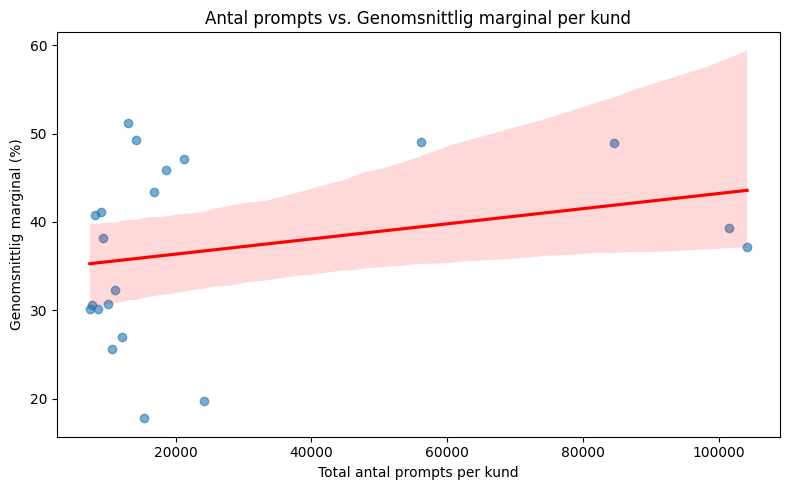

In [78]:
import numpy as np

x = customer_summary["total_prompts"]
y = customer_summary["avg_margin_pct"]

# Pearson-korrelation med NumPy
corr = np.corrcoef(x, y)[0, 1]
print(f"Korrelationskoefficient (Pearson r): {corr:.3f}")

# Scatterplot + regressionslinje
plt.figure(figsize=(8,5))
sns.regplot(
    x=x,
    y=y,
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
plt.title("Antal prompts vs. Genomsnittlig marginal per kund")
plt.xlabel("Total antal prompts per kund")
plt.ylabel("Genomsnittlig marginal (%)")
plt.tight_layout()
plt.show()


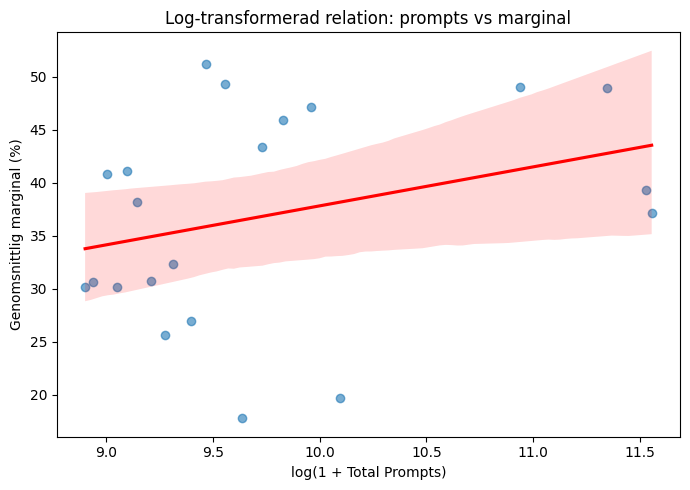

Korrelationskoefficient efter log-transform: 0.316


In [79]:
# Log-transformera total_prompts
customer_summary["log_total_prompts"] = np.log1p(customer_summary["total_prompts"])

plt.figure(figsize=(7,5))
sns.regplot(
    x="log_total_prompts",
    y="avg_margin_pct",
    data=customer_summary,
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
plt.xlabel("log(1 + Total Prompts)")
plt.ylabel("Genomsnittlig marginal (%)")
plt.title("Log-transformerad relation: prompts vs marginal")
plt.tight_layout()
plt.show()

# Korrelationskoefficient efter log-transform
r_log = np.corrcoef(
    customer_summary["log_total_prompts"],
    customer_summary["avg_margin_pct"]
)[0,1]

print(f"Korrelationskoefficient efter log-transform: {r_log:.3f}")


- 5.4 Visualisera: Vilka är våra top 5 bästa kunder sett till användning och lönsamhet?

    jag har skapat en poäng för varje kund baserat på både antal prompts och vinst. jag har tagit båda kolumnerna och gett dem samma skala, så de kan kombineras direkt utan att ena dominerar. Eftersom lägst poäng är bäst så har jag inverterat poängen så den inte visualiseras konstigt så sämst ser ut som bäst. Jag vill ändå visa lönsamheten i barchartet.

C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\1488283516.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\1488283516.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\1488283516.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


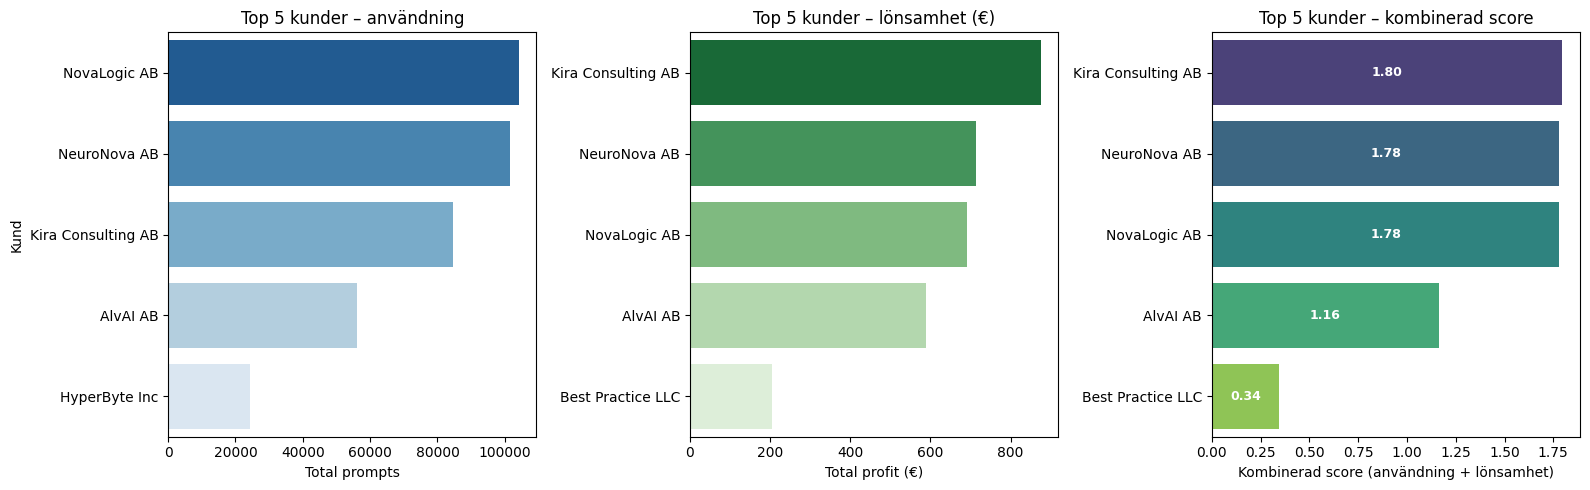

In [80]:
# --- Top 5 efter enskilda mått ---
top_usage = customer_summary.sort_values("total_prompts", ascending=False).head(5)
top_profit = customer_summary.sort_values("total_profit", ascending=False).head(5)

# --- Lägg till kombinerad score (0–1 normalisering) ---
customer_summary["score_prompts"] = (
    (customer_summary["total_prompts"] - customer_summary["total_prompts"].min())
    / (customer_summary["total_prompts"].max() - customer_summary["total_prompts"].min())
)
customer_summary["score_profit"] = (
    (customer_summary["total_profit"] - customer_summary["total_profit"].min())
    / (customer_summary["total_profit"].max() - customer_summary["total_profit"].min())
)
customer_summary["combined_score"] = customer_summary["score_prompts"] + customer_summary["score_profit"]

# Top 5 kunder efter kombinerad score
top_combined = customer_summary.sort_values("combined_score", ascending=False).head(5)

# --- Visualisering: tre diagram bredvid varandra ---
fig, axes = plt.subplots(1, 3, figsize=(16,5))

# 1) Användning
sns.barplot(
    x="total_prompts",
    y="customer_name",
    data=top_usage,
    palette="Blues_r",
    ax=axes[0]
)
axes[0].set_title("Top 5 kunder – användning")
axes[0].set_xlabel("Total prompts")
axes[0].set_ylabel("Kund")

# 2) Lönsamhet
sns.barplot(
    x="total_profit",
    y="customer_name",
    data=top_profit,
    palette="Greens_r",
    ax=axes[1]
)
axes[1].set_title("Top 5 kunder – lönsamhet (€)")
axes[1].set_xlabel("Total profit (€)")
axes[1].set_ylabel("")

# 3) Kombinerad score
bars = sns.barplot(
    x="combined_score",
    y="customer_name",
    data=top_combined,
    palette="viridis",
    ax=axes[2]
)
axes[2].set_title("Top 5 kunder – kombinerad score")
axes[2].set_xlabel("Kombinerad score (användning + lönsamhet)")
axes[2].set_ylabel("")

# Lägg text med exakta värden i kombinerad-score-staplarna
for bar, val in zip(bars.patches, top_combined["combined_score"]):
    bars.text(
        bar.get_width()/2,
        bar.get_y() + bar.get_height()/2,
        f"{val:.2f}",
        ha="center", va="center",
        color="white", fontsize=9, fontweight="bold"
    )

plt.tight_layout()
plt.show()


- 5.5 Du har fått i uppgift att ta fram en ny KPI som ledningen benämner ”Efficiency Index” vilket är ett mått på hur mycket vinst varje kund genererar per 1000 prompts. Du har fått följande formel från ledningsgruppen:

    **efficiency index = (total profit / total prompts) * 1000**

    Skapa denna nya KPI som en ny kolumn i ditt kundaggregerade DataFrame och visualisera efficiency index på ett sätt som gör det enkelt för ledningsgruppen att ta beslut på action.


C:\Users\nylen\AppData\Local\Temp\ipykernel_30936\3418614031.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


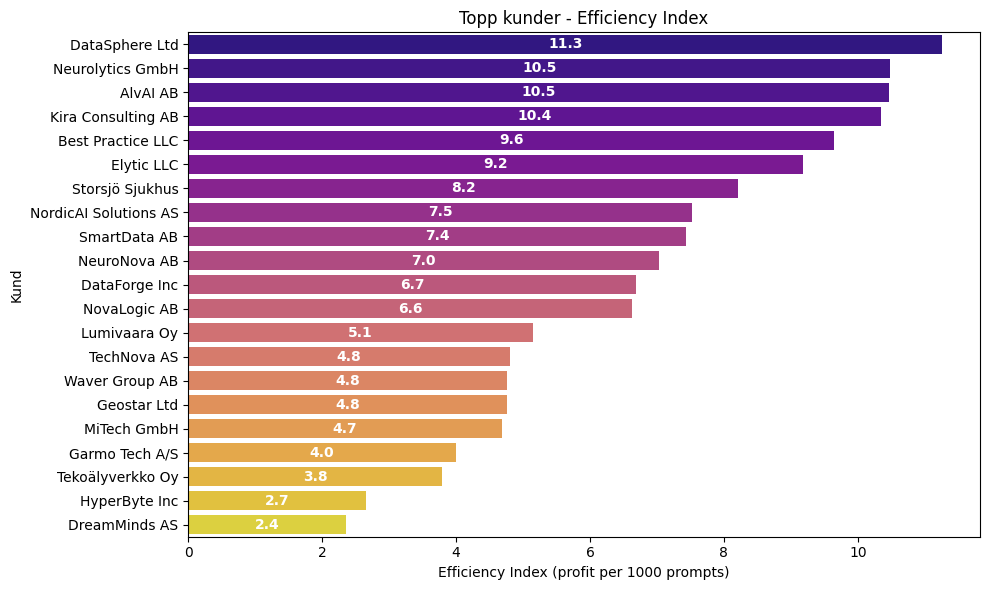

In [ ]:
# Skapa KPI: Efficiency Index
customer_summary["efficiency_index"] = (customer_summary["total_profit"] / customer_summary["total_prompts"]) * 1000

# Sortera alla kunder baserat på Efficiency Index. Om man kan man ändra antalet man vill visa genom att byta värdet i head()
top_efficiency = customer_summary.sort_values("efficiency_index", ascending=False).head(21)

# Horisontellt stapeldiagram
plt.figure(figsize=(10,6))
bars = sns.barplot(
    x="efficiency_index",
    y="customer_name",
    data=top_efficiency,
    palette="plasma"
)

plt.xlabel("Efficiency Index (profit per 1000 prompts)")
plt.ylabel("Kund")
plt.title("Topp kunder - Efficiency Index")

# Lägger till efficiency index värden i staplarna
for bar, value in zip(bars.patches, top_efficiency["efficiency_index"]):
    width = bar.get_width()
    plt.text(
        width/2,                         # mitt i stapeln
        bar.get_y() + bar.get_height()/2,
        f"{value:.1f}",                  # ett decimalformat
        ha="center",
        va="center",
        color="white",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()
